In [1]:
from pathlib import Path
import random
import logging
import numpy as np
import torch
from torch.utils.data import Dataset
import sys
import matplotlib.pyplot as plt
import cv2
import math
try:
    import midaGAN
except ImportError:
    sys.path.append('../')
    import midaGAN
    
from midaGAN.utils.io import make_dataset_of_directories
from midaGAN.utils import sitk_utils
from midaGAN.data.utils.registration_methods import truncate_CT_to_scope_of_CBCT
from midaGAN.data.utils.body_mask import apply_body_mask_and_bound

from viz import show_mid_slices
import SimpleITK as sitk
import time

In [107]:
# Utility function to visualize the mask and bounds
def show_mask_bound(array, mask=None, bound=None):
    for n_slice in range(array.shape[0]):
        if mask is not None:
            fig, axs = plt.subplots(1, 2)
        else:
            fig, axs = plt.subplots(1, 1)
            
        img = array[n_slice]
        if bound is not None:
            cv2.rectangle(img, (bound[2][0], bound[1][0]), (bound[2][1], bound[1][1]), 3000, 2)
        
        if isinstance(axs, list):
            axs[0].imshow(img, cmap='gray')    
        else:
            axs.imshow(img, cmap='gray')    

        if mask is not None:
            axs[1].imshow(mask[n_slice], cmap='gray')
        plt.show()

In [108]:
EXTENSIONS = ['.nrrd']

root_path = Path('/mnt/14F117A002BC354B/maastro_proton_cbct_ct_processed/')

# take from the dataset class of the maastro_lung_proton_cbct_to_ct project
paths_CBCT = []
paths_CT = []
for patient in root_path.iterdir():
    if (patient / "CBCT").is_dir():
        paths_CBCT.extend(make_dataset_of_directories(patient / "CBCT", EXTENSIONS))
    if (patient / "CT").is_dir():
        paths_CT.extend(make_dataset_of_directories(patient / "CT", EXTENSIONS))

In [122]:
path_CBCT = random.choice(paths_CBCT)
path_CT = random.choice(paths_CT)

In [123]:
# load nrrd as SimpleITK objects
CBCT = sitk_utils.load(Path(path_CBCT) / 'CBCT.nrrd')
# Remove warped slices in CBCT
num_slices = sitk_utils.get_size(CBCT)[-1]
start_slice = int(num_slices * 0.13)
end_slice = int(num_slices * 0.82)
CBCT = sitk_utils.slice_image(CBCT, start=(0, 0, start_slice), end=(-1, -1, end_slice))

In [124]:
CT = sitk_utils.load(Path(path_CT) / 'CT.nrrd')

In [125]:
CT_truncated = truncate_CT_to_scope_of_CBCT(CT, CBCT)

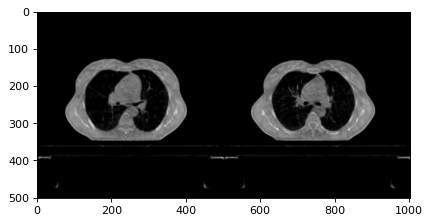

In [126]:
show_mid_slices(CBCT, show_axis=(False, False, True))

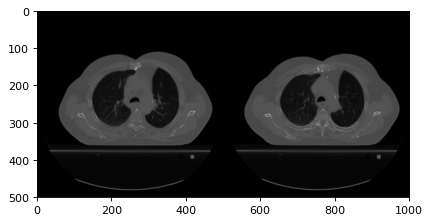

In [127]:
show_mid_slices(CT_truncated, show_axis=(False, False, True))

In [128]:
CBCT_array = sitk.GetArrayFromImage(CBCT)

start_time = time.time()
masked_CBCT_array = apply_body_mask_and_bound(CBCT_array, apply_mask=True, apply_bound=True, hu_threshold=-800, masking_value=-1000)
print(f"Time taken for masking: {time.time() - start_time}")

Time taken for masking: 20.33156967163086


In [116]:
print(CBCT_array.min())

-1000


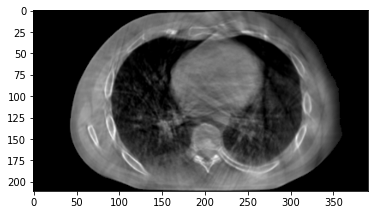

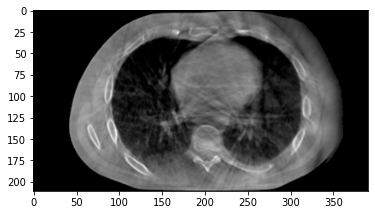

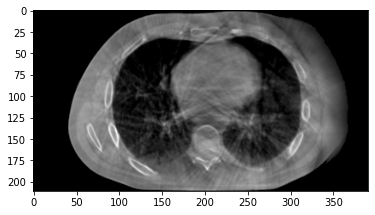

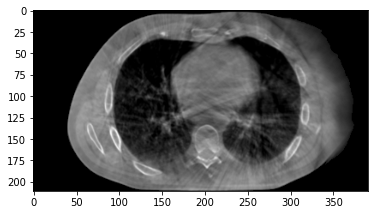

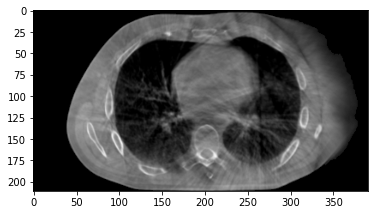

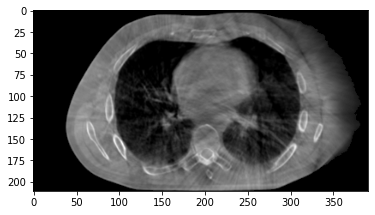

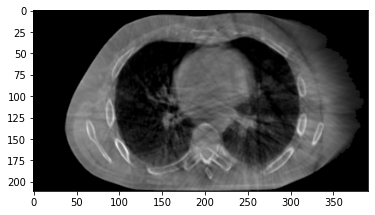

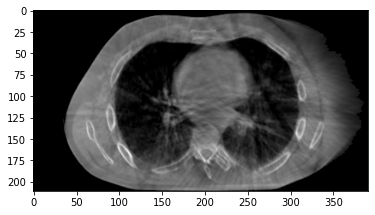

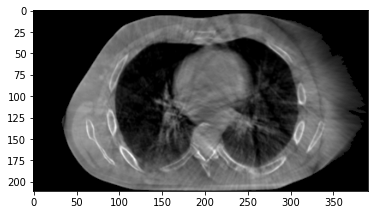

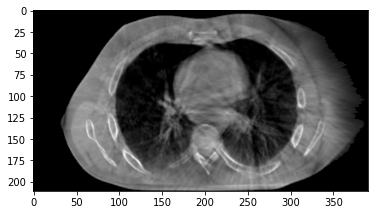

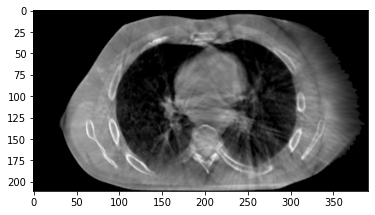

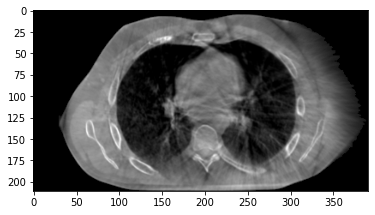

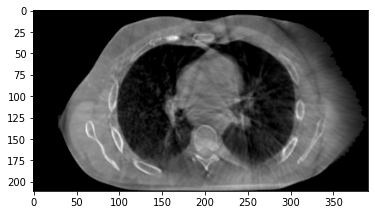

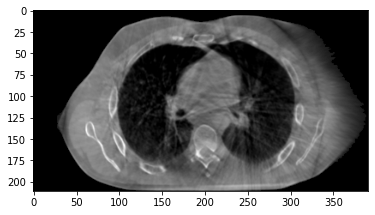

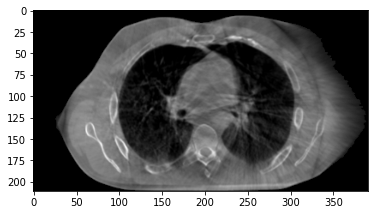

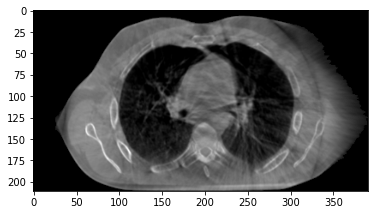

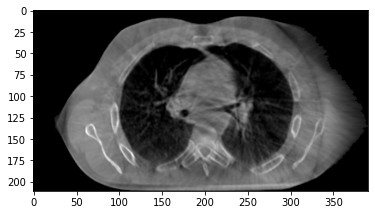

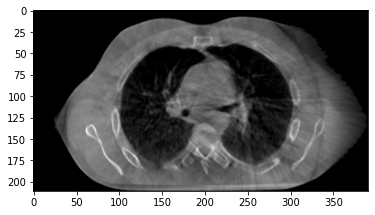

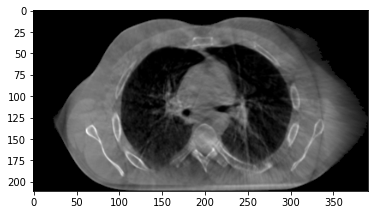

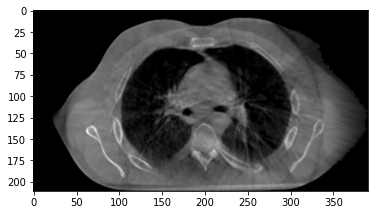

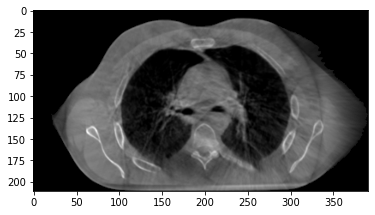

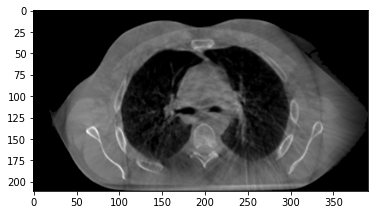

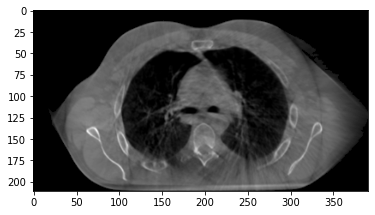

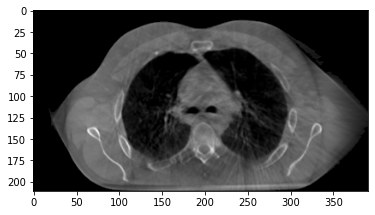

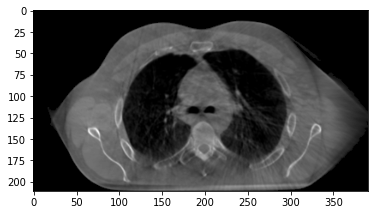

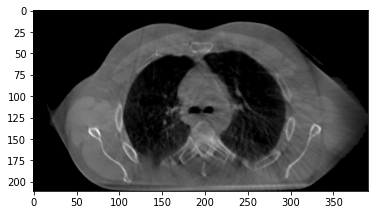

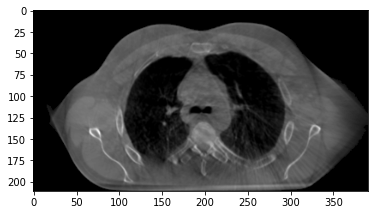

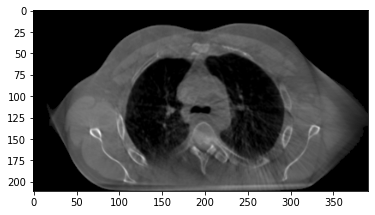

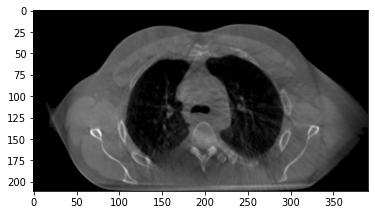

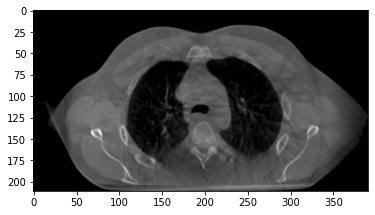

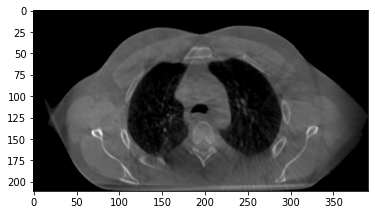

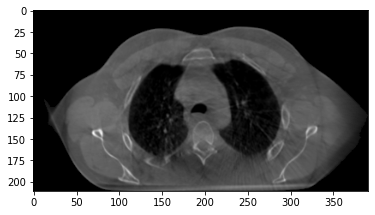

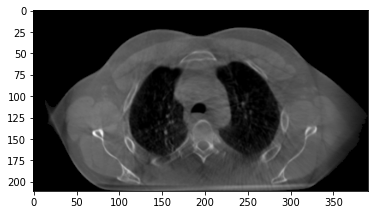

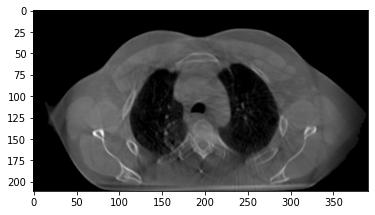

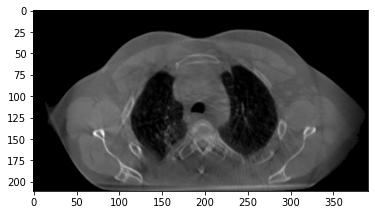

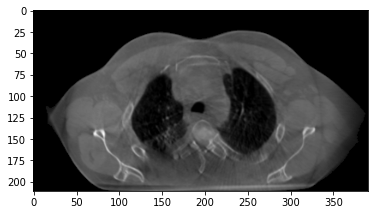

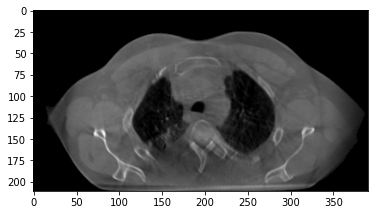

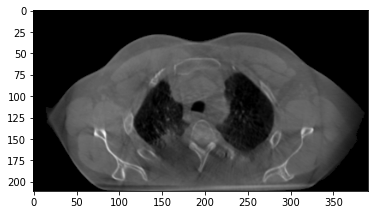

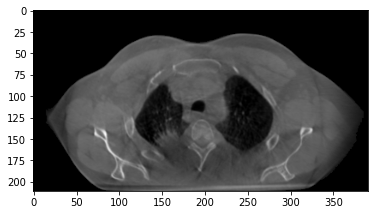

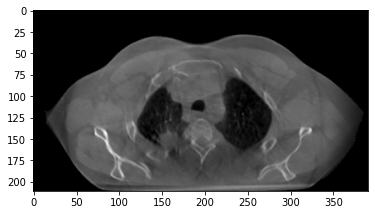

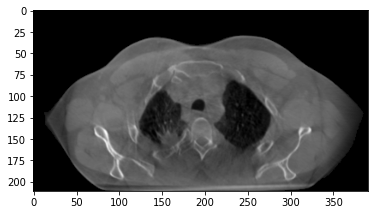

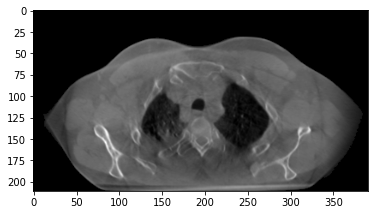

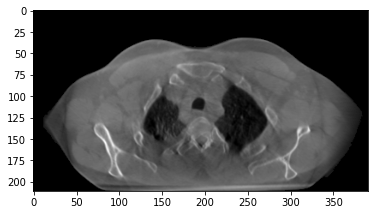

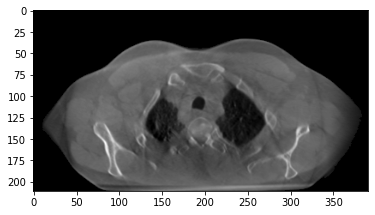

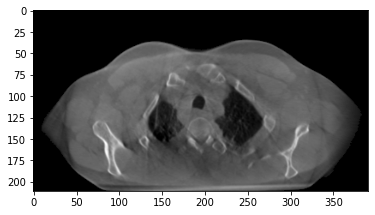

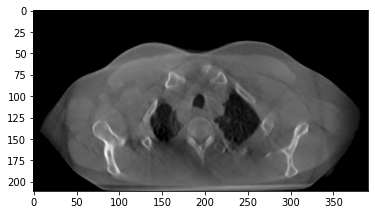

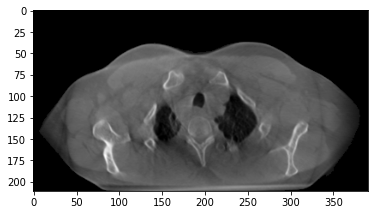

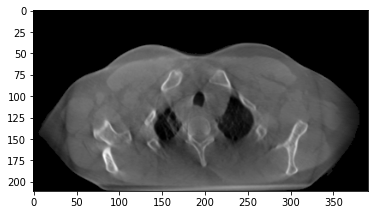

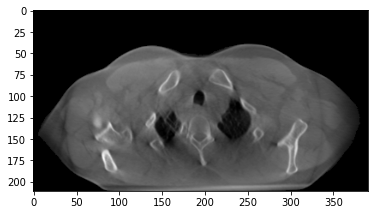

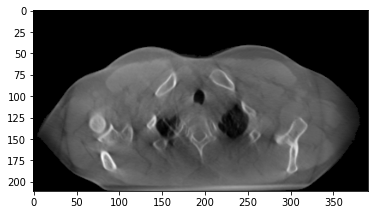

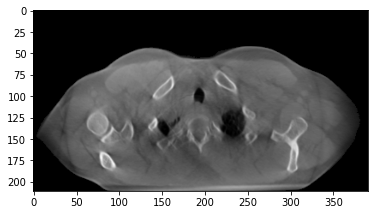

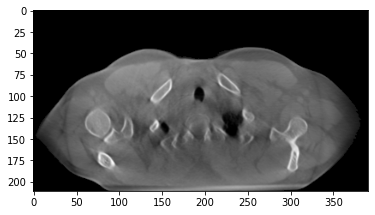

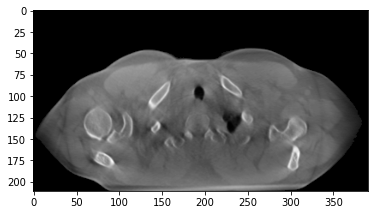

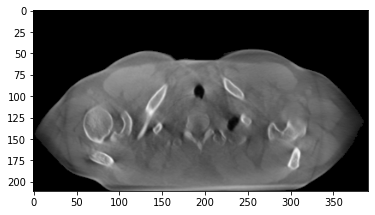

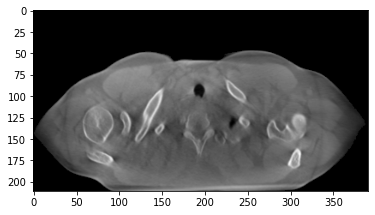

In [117]:
show_mask_bound(masked_CBCT_array)

In [118]:
#show_mask_bound(CBCT_array)

In [129]:
CT_array = sitk.GetArrayFromImage(CT_truncated)
CT_array = apply_body_mask_and_bound(CT_array, apply_mask=True, apply_bound=True, hu_threshold=-600, masking_value=-1000)
CT_array.shape

(53, 214, 350)

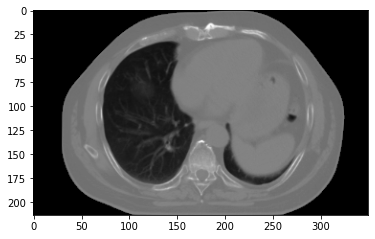

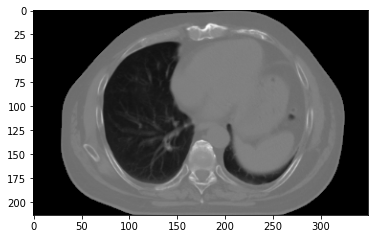

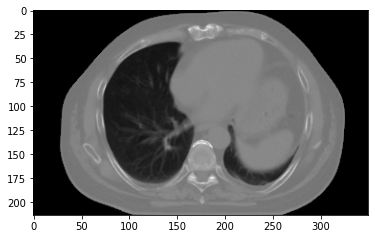

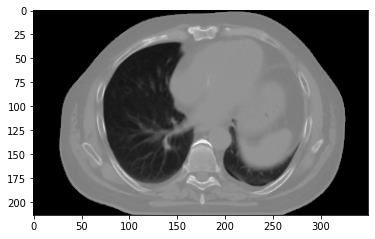

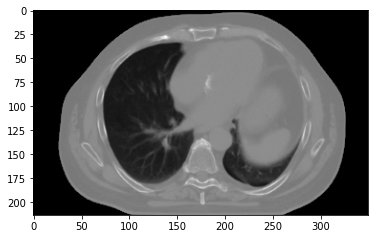

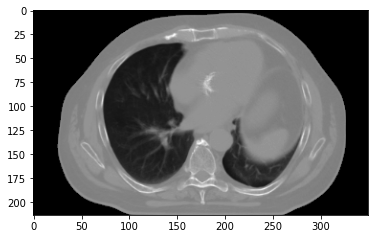

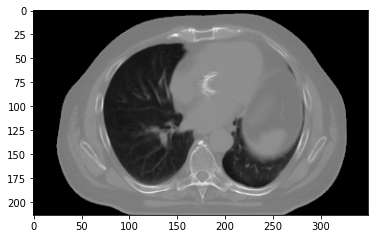

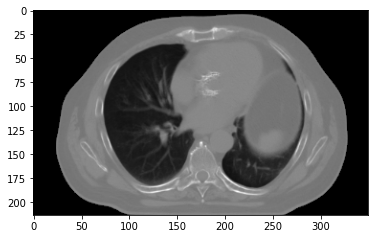

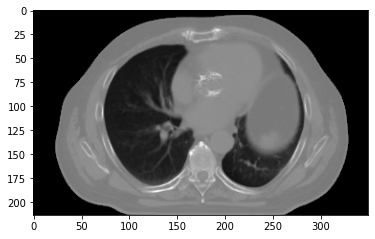

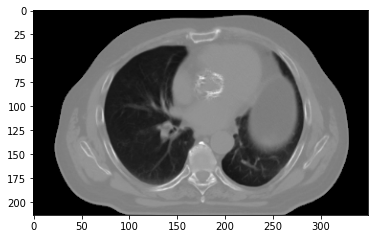

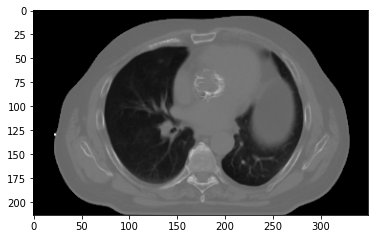

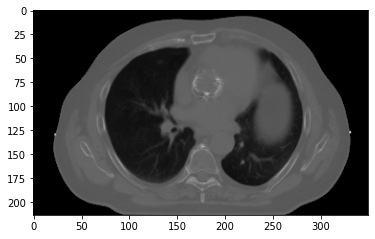

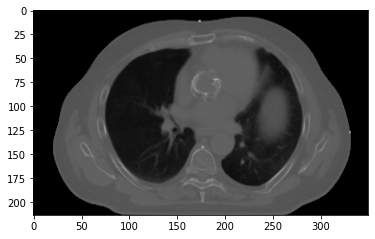

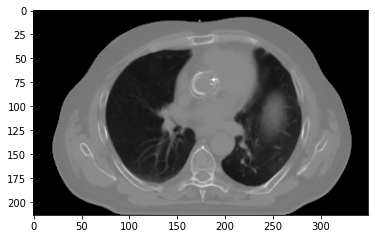

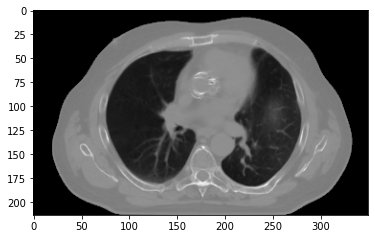

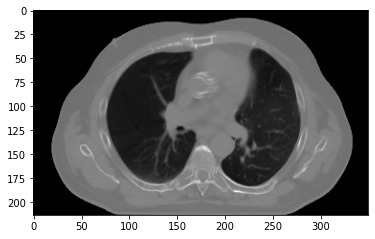

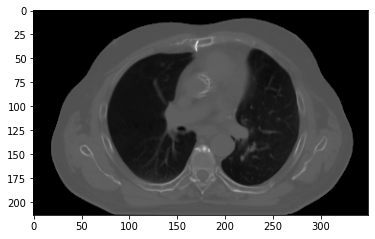

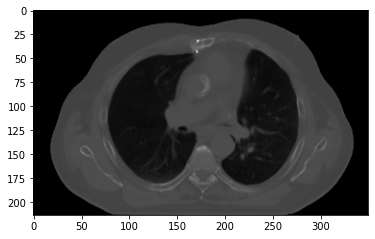

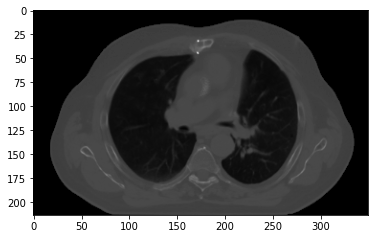

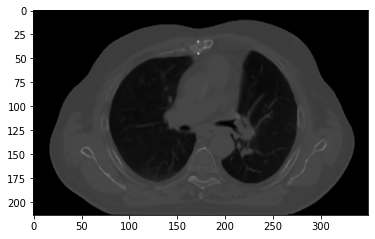

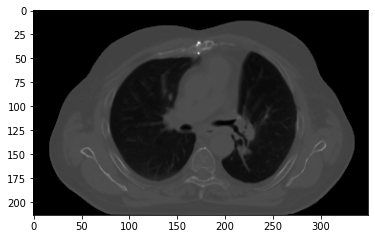

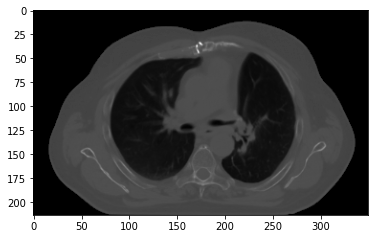

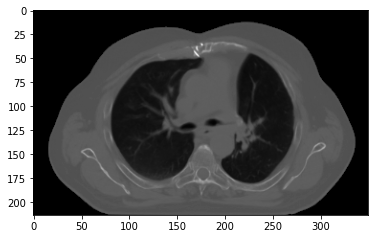

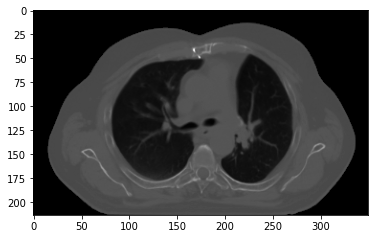

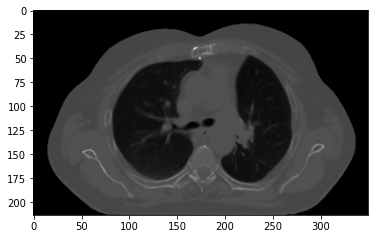

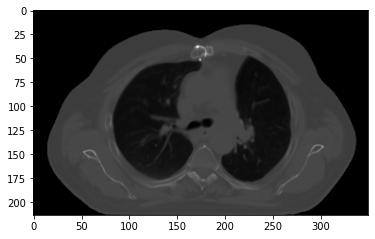

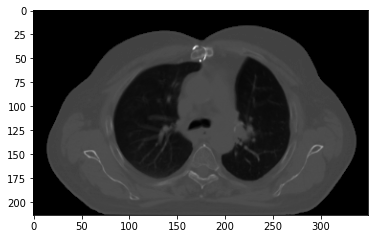

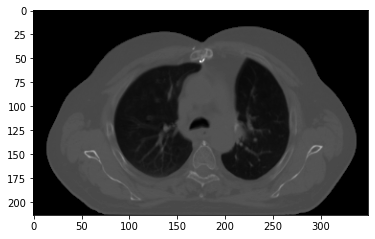

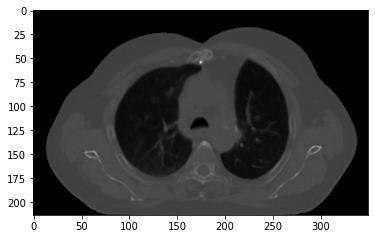

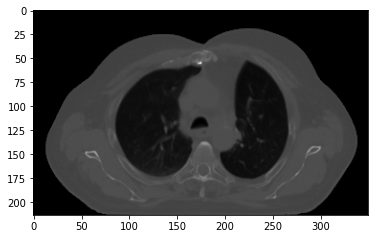

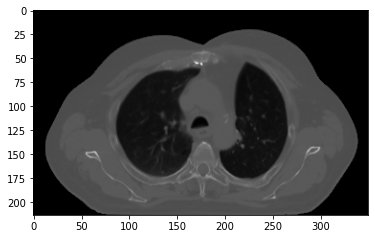

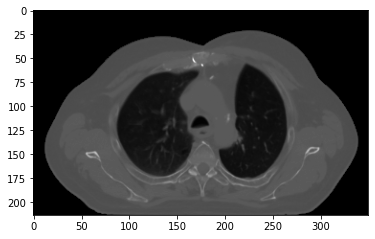

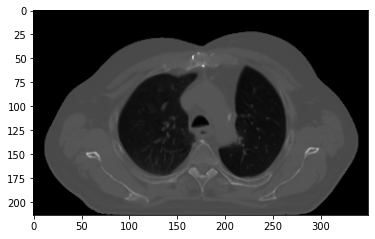

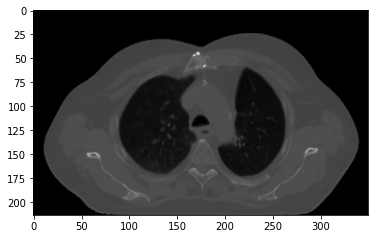

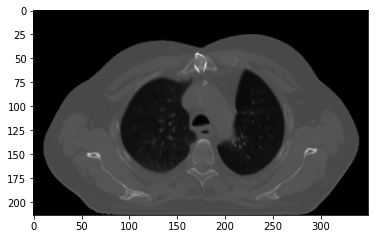

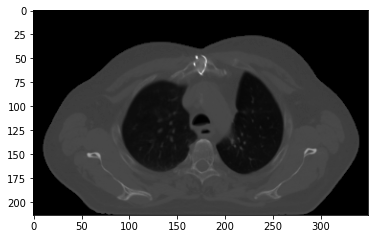

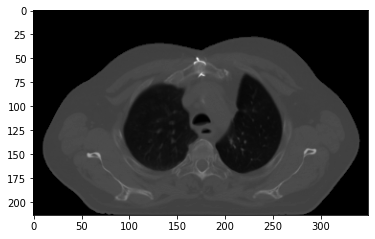

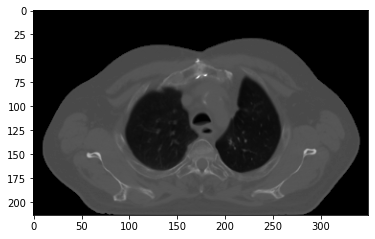

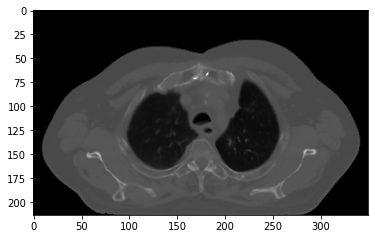

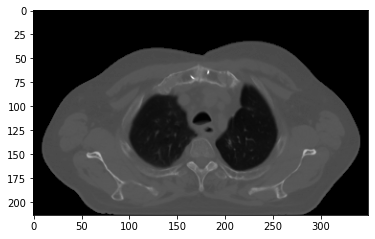

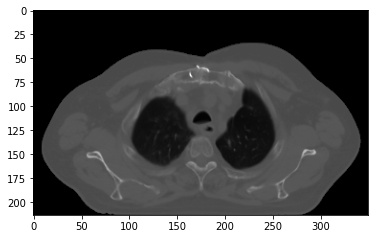

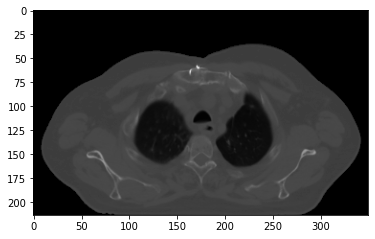

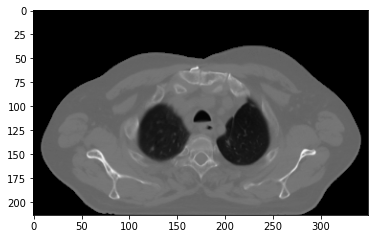

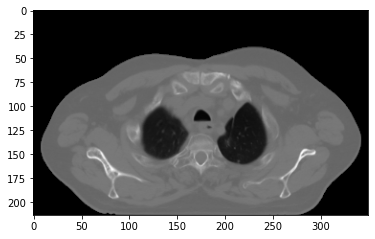

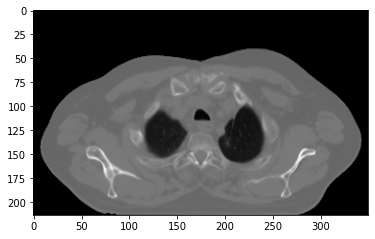

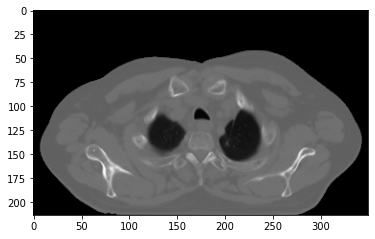

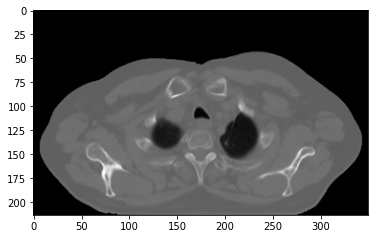

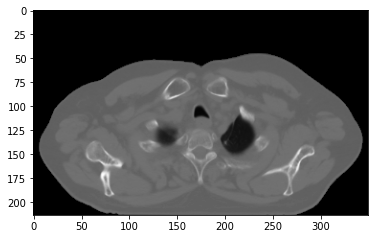

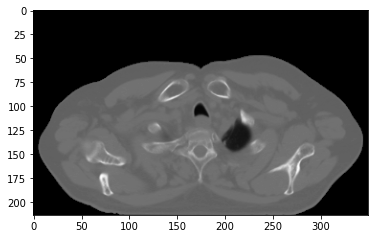

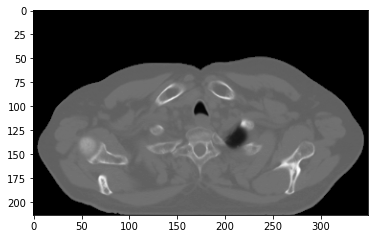

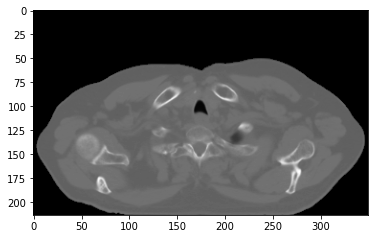

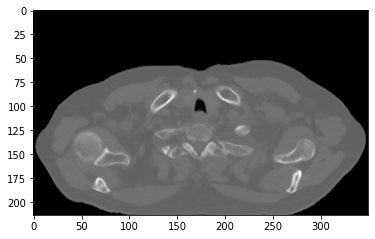

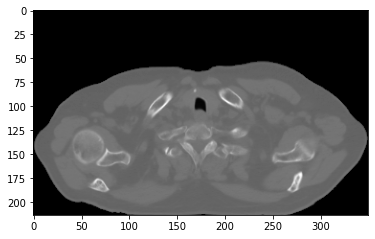

In [130]:
show_mask_bound(CT_array)

In [ ]:
original = sitk.GetImageFromArray(CBCT_array)
original.SetSpacing(CBCT.GetSpacing())
original.SetOrigin(CBCT.GetOrigin())
original.SetDirection(CBCT.GetDirection())
sitk.WriteImage(original, 'original.nrrd', True)

In [ ]:
masked = sitk.GetImageFromArray(masked_CBCT_array)
masked.SetSpacing(CBCT.GetSpacing())
masked.SetOrigin(CBCT.GetOrigin())
masked.SetDirection(CBCT.GetDirection())
sitk.WriteImage(masked, 'output.nrrd', True)